# Light curve estimation

## Introduction

This tutorial presents a new light curve estimator that works with dataset objects. We will demonstrate how to compute a `~gammapy.time.LightCurve` from 3D data cubes as well as 1D spectral data using the `~gammapy.cube.MapDataset`, `~gammapy.spectrum.SpectrumDatasetOnOff` and `~gammapy.time.LightCurveEstimator` classes. 

We will use the four Crab nebula observations from the [H.E.S.S. first public test data release](https://www.mpi-hd.mpg.de/hfm/HESS/pages/dl3-dr1/) and compute per-observation fluxes. The Crab nebula is not known to be variable at TeV energies, so we expect constant brightness within statistical and systematic errors.

## Setup

As usual, we'll start with some general imports...

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import astropy.units as u
from astropy.coordinates import SkyCoord
import logging

log = logging.getLogger(__name__)

Now let's import gammapy specific classes and functions

In [2]:
from gammapy.data import DataStore
from gammapy.modeling.models import PowerLawSpectralModel
from gammapy.modeling.models import PointSpatialModel
from gammapy.modeling.models import SkyModel
from gammapy.cube import MapDatasetMaker, MapDataset, SafeMaskMaker
from gammapy.maps import WcsGeom, MapAxis
from gammapy.time import LightCurveEstimator

## Select the data

We look for relevant observations in the datastore.

In [3]:
data_store = DataStore.from_dir("$GAMMAPY_DATA/hess-dl3-dr1/")
mask = data_store.obs_table["TARGET_NAME"] == "Crab"
obs_ids = data_store.obs_table["OBS_ID"][mask].data
crab_obs = data_store.get_observations(obs_ids)

## Define time intervals
We create a list of time intervals. Here we use one time bin per observation.

In [4]:
time_intervals = [(obs.tstart, obs.tstop) for obs in crab_obs]

## 3D data reduction 

### Define the analysis geometry

Here we define the geometry used in the analysis. We use the same WCS map structure but we use two different binnings for reco and true energy axes. This allows for a broader coverage of the response.

In [5]:
# Target definition
target_position = SkyCoord(ra=83.63308, dec=22.01450, unit="deg")

# Define geoms
emin, emax = [0.7, 10] * u.TeV
energy_axis = MapAxis.from_bounds(
    emin.value, emax.value, 10, unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=target_position,
    binsz=0.02,
    width=(2, 2),
    coordsys="CEL",
    proj="CAR",
    axes=[energy_axis],
)

energy_axis_true = MapAxis.from_bounds(
    0.1, 20, 20, unit="TeV", name="energy", interp="log"
)

offset_max = 2 * u.deg

### Define the 3D model 

The light curve is based on a 3D fit of a map dataset in time bins. We therefore need to define the source model to be applied. Here a point source with power law spectrum. We freeze its parameters assuming they were previously extracted

In [6]:
# Define the source model - Use a pointsource + integrated power law model to directly get flux

spatial_model = PointSpatialModel(
    lon_0=target_position.ra, lat_0=target_position.dec, frame="icrs"
)

spectral_model = PowerLawSpectralModel(
    index=2.6,
    amplitude=2.0e-11 * u.Unit("1 / (cm2 s TeV)"),
    reference=1 * u.TeV,
)
spectral_model.parameters["index"].frozen = False

sky_model = SkyModel(
    spatial_model=spatial_model, spectral_model=spectral_model, name=""
)
sky_model.parameters["lon_0"].frozen = True
sky_model.parameters["lat_0"].frozen = True

### Make the map datasets

The following function is in charge of the MapDataset production. It will later be fully covered in the data reduction chain 

Now we perform the actual data reduction in time bins

In [7]:
%%time

datasets = []

maker = MapDatasetMaker(offset_max=offset_max)
maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=offset_max)

for time_interval in time_intervals:
    # get filtered observation lists in time interval
    observations = crab_obs.select_time(time_interval)

    # Proceed with further analysis only if there are observations
    # in the selected time window
    if len(observations) == 0:
        log.warning(f"No observations in time interval: {time_interval}")
        continue

    stacked = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true)

    for obs in observations:
        dataset = maker.run(stacked, obs)
        dataset = maker_safe_mask.run(dataset, obs)
        stacked.stack(dataset)

    # TODO: remove once IRF maps are handled correctly in fit
    stacked.edisp = stacked.edisp.get_energy_dispersion(
        position=target_position, e_reco=energy_axis.edges
    )

    stacked.psf = stacked.psf.get_psf_kernel(
        position=target_position,
        geom=stacked.exposure.geom,
        max_radius="0.3 deg",
    )

    datasets.append(stacked)

/home/ljouvin/installation_python/miniconda3/envs/gammapy-dev/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/ljouvin/installation_gammapy/gammapy/gammapy/cube/psf_kernel.py:109: RuntimeWarning: invalid value encountered in true_divide
  img += vals.value / vals.sum().value


CPU times: user 2.12 s, sys: 68.1 ms, total: 2.19 s
Wall time: 2.18 s


## Light Curve estimation: the 3D case

Now that we have created the datasets we assign them the model to be fitted:

In [8]:
for dataset in datasets:
    # Copy the source model
    model = sky_model.copy(name="crab")
    dataset.model = model

We can now create the light curve estimator by passing it the list of datasets. 
We can optionally ask for parameters reoptimization during fit, e.g. to fit background normalization in each time bin.

In [9]:
lc_maker = LightCurveEstimator(datasets, source="crab", reoptimize=True)

We now run the estimator once we pass it the energy interval on which to compute the integral flux of the source.

In [10]:
%%time
lc = lc_maker.run(e_ref=1 * u.TeV, e_min=1.0 * u.TeV, e_max=10.0 * u.TeV)

CPU times: user 13 s, sys: 61.2 ms, total: 13 s
Wall time: 13 s


The LightCurve object contains a table which we can explore.

In [11]:
lc.table["time_min", "time_max", "flux", "flux_err"]

time_min,time_max,flux,flux_err
,,1 / (cm2 s),1 / (cm2 s)
float64,float64,float64,float64
53343.92234009259,53343.94186555556,2.5854277282288015e-11,1.9875463397770685e-12
53343.95421509259,53343.97369425926,2.319630064068609e-11,1.9201169445408757e-12
53345.96198129629,53345.98149518518,2.995335044221267e-11,2.647801685325784e-12
53347.913196574074,53347.93271046296,2.752076433659184e-11,2.4998874622862153e-12


We finally plot the light curve

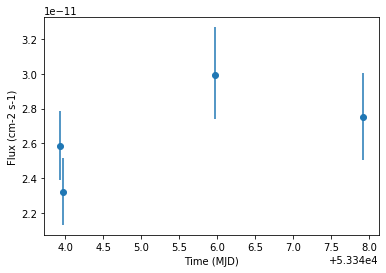

In [12]:
lc.plot(marker="o")

## Performing the same analysis with 1D spectra

### First the relevant imports

We import the missing classes for spectral data reduction

In [13]:
from regions import CircleSkyRegion
from astropy.coordinates import Angle
from gammapy.spectrum import (
    SpectrumDatasetMaker,
    ReflectedRegionsBackgroundMaker,
)

### Defining the geometry

We need to define the ON extraction region. We will keep the same reco and true energy axes as in 3D.

In [14]:
# Target definition
e_reco = np.logspace(-1, np.log10(40), 40) * u.TeV
e_true = np.logspace(np.log10(0.05), 2, 100) * u.TeV

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=target_position, radius=on_region_radius)

In [15]:
dataset_maker = SpectrumDatasetMaker(
    region=on_region, e_reco=e_reco, e_true=e_true, containment_correction=True
)
bkg_maker = ReflectedRegionsBackgroundMaker()
safe_mask_masker = SafeMaskMaker(methods=["aeff-max"], aeff_percent=10)

### Creation of the datasets

In [16]:
datasets_1d = []

for time_interval in time_intervals:
    observation = crab_obs.select_time(time_interval)[0]

    dataset = dataset_maker.run(
        observation, selection=["counts", "aeff", "edisp"]
    )

    dataset_on_off = bkg_maker.run(dataset, observation)
    dataset_on_off = safe_mask_masker.run(dataset_on_off, observation)
    datasets_1d.append(dataset_on_off)

/home/ljouvin/installation_gammapy/gammapy/gammapy/utils/interpolation.py:159: Warning: Interpolated values reached float32 precision limit
  "Interpolated values reached float32 precision limit", Warning


## Light Curve estimation for 1D spectra

Now that we've reduced the 1D data we assign again the model to the datasets 

In [17]:
for dataset in datasets_1d:
    # Copy the source model
    model = spectral_model.copy()
    model.name = "crab"
    dataset.model = model

We can now call the LightCurveEstimator in a perfectly identical manner.

In [18]:
lc_maker_1d = LightCurveEstimator(datasets_1d, source="crab", reoptimize=False)

In [19]:
%%time
lc_1d = lc_maker_1d.run(e_ref=1 * u.TeV, e_min=1.0 * u.TeV, e_max=10.0 * u.TeV)

CPU times: user 161 ms, sys: 0 ns, total: 161 ms
Wall time: 159 ms


### Compare results

Finally we compare the result for the 1D and 3D lightcurve in a single figure:

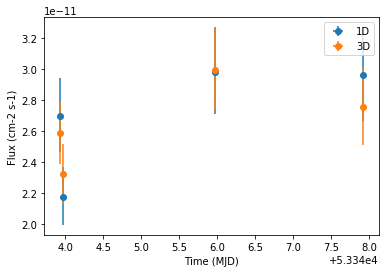

In [20]:
ax = lc_1d.plot(marker="o", label="1D")
lc.plot(ax=ax, marker="o", label="3D")
plt.legend()